In [1]:
# prerequisites
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from scipy.stats import norm
from sklearn.metrics import roc_curve,roc_auc_score

Using TensorFlow backend.


In [91]:
def mergeSample(ix1_te,ix1_tr,ix2_te,ix2_tr):
    #Now lets build a sample with signal and sideband merged
    ix_tr = np.concatenate((ix1_tr,ix2_tr))
    ix_te = np.concatenate((ix1_te,ix2_te))

    #Need to define the y
    iy_te1tmp  = np.zeros(len(ix1_te))
    iy_te2tmp  = np.ones(len(ix2_te))
    iy_te      = np.concatenate((iy_te1tmp,iy_te2tmp)) 
    iy_tr1tmp  = np.zeros (len(ix1_tr))
    iy_tr2tmp  = np.ones  (len(ix2_tr))
    iy_tr      = np.concatenate((iy_tr1tmp,iy_tr2tmp)) 
    iy_teO     = np.eye(2)[((iy_te)).astype(int)]
    iy_trO     = np.eye(2)[((iy_tr)).astype(int)]
    return ix_tr,ix_te,iy_trO,iy_teO
    
def random_sample(iXArr,iYArr,iDilution):
    tmp = np.arange(0,len(iXArr))
    np.random.shuffle(tmp)
    tmp = tmp[0:int(len(tmp)*iDilution)]
    iXArr = iXArr[tmp]
    iYArr = iYArr[tmp]
    return iXArr,iYArr

def random_split(iXArr,iYArr,iDilution):
    tmp = np.arange(0,len(iXArr))
    np.random.shuffle(tmp)
    tmp1 = tmp[0:int(len(tmp)*iDilution)]
    tmp2 = tmp[int(len(tmp)*iDilution):int(len(tmp))]
    iXArr1 = iXArr[tmp1]
    iYArr1 = iYArr[tmp1]
    iXArr2 = iXArr[tmp2]
    iYArr2 = iYArr[tmp2]
    return iXArr1,iYArr1,iXArr2,iYArr2


In [24]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

#Our mystery digit will be 9

#Now lets prepare a search where we just have 5 and 9
x_te5 = x_te[(y_te == 5)]
y_te5 = y_te[(y_te == 5)]
x_tr5 = x_tr[(y_tr == 5)]
y_tr5 = y_tr[(y_tr == 5)]

x_te9 = x_te[(y_te == 9)]
y_te9 = y_te[(y_te == 9)]
x_tr9 = x_tr[(y_tr == 9)]
y_tr9 = y_tr[(y_tr == 9)]

#And merge
x_te59 = x_te[np.logical_or((y_te == 5),(y_te == 9))]
y_te59 = y_te[np.logical_or((y_te == 5),(y_te == 9))]
x_tr59 = x_tr[np.logical_or((y_tr == 5),(y_tr == 9))]
y_tr59 = y_tr[np.logical_or((y_tr == 5),(y_tr == 9))]
y_te59 = np.eye(2)[((y_te59-5)*0.25).astype(int)]
y_tr59 = np.eye(2)[((y_tr59-5)*0.25).astype(int)]
x_tr559,x_te559,y_tr559,y_te559 = mergeSample(x_te5,x_tr5,x_te59,x_tr59)

In [93]:
#Now lets make a dilted signal region
dilution=0.01
x_te9d, y_te9d = random_sample(x_te9,y_te9,dilution)
x_tr9d, y_tr9d = random_sample(x_tr9,y_tr9,dilution)
x_te5m1, y_te5m1,x_te5m2, y_te5m2 = random_split(x_te5,y_te5,0.5)
x_tr5m1, y_tr5m1,x_tr5m2, y_tr5m2 = random_split(x_tr5,y_tr5,0.5)

x_tr59d,x_te59d,y_tr59d,y_te59d     = mergeSample(x_te5m1,x_tr5m1,x_te9d,x_tr9d)
x_tr559d,x_te559d,y_tr559d,y_te559d = mergeSample(x_te5m2,x_tr5m2,x_te59d,x_tr59d)

In [5]:
#now lets make the model
batch_size, n_epoch = 1, 15
n_hidden, z_dim = 256, 4

# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

#VAE Model
def makeModel(ix_tr):
    # encoder
    x = Input(shape=(ix_tr.shape[1:]))
    x_encoded = Dense(n_hidden, activation='relu')(x)
    x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

    mu = Dense(z_dim)(x_encoded)
    log_var = Dense(z_dim)(x_encoded)
    z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])    

    # decoder
    z_decoder1 = Dense(n_hidden//2, activation='relu')
    z_decoder2 = Dense(n_hidden, activation='relu')
    y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

    z_decoded = z_decoder1(z)
    z_decoded = z_decoder2(z_decoded)
    y = y_decoder(z_decoded)
    
    # loss
    reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    vae_loss = reconstruction_loss + kl_loss
    
    vae = Model(x, y)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    #vae.summary()
    
    # build decoder
    decoder_input = Input(shape=(z_dim,))
    _z_decoded    = z_decoder1(decoder_input)
    _z_decoded    = z_decoder2(_z_decoded)
    _y            = y_decoder(_z_decoded)
    generator = Model(decoder_input, _y)
    return vae,generator,x,y,mu,vae_loss

#Classifier Model
def classifierModel(ix_tr,n_hidden=32):
    x = Input(shape=(ix_tr.shape[1:]))
    x_encoded = Dense(n_hidden, activation='relu')(x)
    x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
    x_encoded = Dense(8, activation='relu')(x_encoded)
    y = Dense(2, activation='softmax')(x_encoded)
    classifier = Model(x, y)
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classifier,x,y

#now lets compare the loss functions between 5 and 9
def vaeloss(vaemodel,ix):
        result = objectives.binary_crossentropy(ix,vaemodel.predict(ix, batch_size=batch_size))* ix.shape[1]
        return result

In [6]:
#Now lets train a VAE on just 5 and 9
vae5,gen5,x5,y5,mu5,vae_loss5 = makeModel(x_tr5)
vae5.fit(x_tr5,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te5, None), verbose=1)

#Now lets train a VAE on just 5
vae9,gen9,x9,y9,mu9,vae_loss9 = makeModel(x_tr9)
vae9.fit(x_tr9,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te9, None), verbose=1)

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_7 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_7.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5421 samples, validate on 892 samples
Epoch 1/15
5421/5421 [==============================] - 13s 2ms/step - loss: 147.3501 - val_loss: 133.9150
Epoch 2/15
5421/5421 [==============================] - 12s 2ms/step - loss: 133.5835 - val_loss: 133.3598
Epoch 3/15
5421/5421 [==============================] - 12s 2ms/step - loss: 132.1612 - val_loss: 131.4305
Epoch 4/15
5421/5421 [==============================] - 12s 2ms/step - loss: 131.9848 - val_loss: 131.6593
Epoch 5/15
5421/5421 [==============================] - 12s 2ms/step - loss: 131.8884 - val_loss: 131.1746
Epoch 6/15
5421/5421 [==============================] - 12s 2ms/step - loss: 131.9348 - val_loss: 132.1954
Epoch 7/15
5421/5421 [==============================] - 12s 2ms/step - loss: 132.2954 - val_loss: 133.2809
Epoch 8/15
5421/5421 [==============================] - 13s 2ms/step - loss: 132.5205 - val_loss: 134.1505
Epoch 9/15
5421/5421 [==============================] - 12s 2ms/step - loss: 132.7813 - val_loss:

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_14 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_14.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5949 samples, validate on 1009 samples
Epoch 1/15
5949/5949 [==============================] - 13s 2ms/step - loss: 120.3122 - val_loss: 109.4815
Epoch 2/15
5949/5949 [==============================] - 13s 2ms/step - loss: 109.8107 - val_loss: 108.7922
Epoch 3/15
5949/5949 [==============================] - 13s 2ms/step - loss: 108.5224 - val_loss: 106.4165
Epoch 4/15
5949/5949 [==============================] - 13s 2ms/step - loss: 108.3752 - val_loss: 107.1216
Epoch 5/15
5949/5949 [==============================] - 13s 2ms/step - loss: 108.3919 - val_loss: 108.3104
Epoch 6/15
5949/5949 [==============================] - 14s 2ms/step - loss: 108.5767 - val_loss: 107.2792
Epoch 7/15
5949/5949 [==============================] - 12s 2ms/step - loss: 108.7560 - val_loss: 107.4682
Epoch 8/15
5949/5949 [==============================] - 13s 2ms/step - loss: 108.9947 - val_loss: 108.4290
Epoch 9/15
5949/5949 [==============================] - 12s 2ms/step - loss: 109.1872 - val_loss

In [13]:
#now lets try the CWOLA approach with VAEs
#In this scenario we train a VAE on 5+9 merged. 
#Lets do it for our diluted signal sample and full sample
vae59,gen59,x59,y59,mu59,vae_loss59 = makeModel(x_tr59)
vae59.fit(x_tr59,
       shuffle=True,
       epochs=n_epoch,
       batch_size=10,
       validation_data=(x_te59, None), verbose=1)

vae59d,gen59d,x59d,y59d,mu59d,vae_loss59d = makeModel(x_tr59d)
vae59d.fit(x_tr59d,
       shuffle=True,
       epochs=n_epoch,
       batch_size=10,
       validation_data=(x_te59d, None), verbose=1)

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_35 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_35.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 11370 samples, validate on 1901 samples
Epoch 1/15
11370/11370 [==============================] - 3s 269us/step - loss: 141.8234 - val_loss: 122.9781
Epoch 2/15
11370/11370 [==============================] - 3s 247us/step - loss: 119.6848 - val_loss: 117.0986
Epoch 3/15
11370/11370 [==============================] - 3s 264us/step - loss: 116.3076 - val_loss: 115.1816
Epoch 4/15
11370/11370 [==============================] - 3s 273us/step - loss: 114.6418 - val_loss: 114.1693
Epoch 5/15
11370/11370 [==============================] - 3s 243us/step - loss: 113.6587 - val_loss: 113.2791
Epoch 6/15
11370/11370 [==============================] - 3s 255us/step - loss: 112.9323 - val_loss: 113.1390
Epoch 7/15
11370/11370 [==============================] - 3s 247us/step - loss: 112.3390 - val_loss: 112.5937
Epoch 8/15
11370/11370 [==============================] - 3s 229us/step - loss: 111.8040 - val_loss: 112.1825
Epoch 9/15
11370/11370 [==============================] - 3s 225us/step

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_42 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_42.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5480 samples, validate on 902 samples
Epoch 1/15
5480/5480 [==============================] - 1s 253us/step - loss: 163.9725 - val_loss: 139.0550
Epoch 2/15
5480/5480 [==============================] - 1s 267us/step - loss: 133.2306 - val_loss: 129.7918
Epoch 3/15
5480/5480 [==============================] - 2s 323us/step - loss: 128.4865 - val_loss: 127.6628
Epoch 4/15
5480/5480 [==============================] - 1s 251us/step - loss: 126.4125 - val_loss: 126.3298
Epoch 5/15
5480/5480 [==============================] - 1s 248us/step - loss: 125.0597 - val_loss: 125.3748
Epoch 6/15
5480/5480 [==============================] - 1s 244us/step - loss: 123.9977 - val_loss: 124.5643
Epoch 7/15
5480/5480 [==============================] - 1s 244us/step - loss: 123.0939 - val_loss: 124.1163
Epoch 8/15
5480/5480 [==============================] - 1s 244us/step - loss: 122.2594 - val_loss: 123.1181
Epoch 9/15
5480/5480 [==============================] - 1s 247us/step - loss: 121.4147 - 

In [66]:
#now lets train all our classifiers
def classify(iX_tr,iX_te,iY_tr,iY_te,iNHidden,iEpochs=20,iBatch=20):
    imodel,ixv,iyv = classifierModel(iX_tr,iNHidden)
    imodel.fit(iX_tr,iY_tr,shuffle=True,epochs=iEpochs,batch_size=iBatch,validation_data=(iX_te,iY_te), verbose=1)
    return imodel

def lossClassify(iX_tr,iX_te,iY_tr,iY_te,iNHidden,iVAEs,iEpochs=20,iBatch=20):
    iX_tr_loss = []
    iX_te_loss = []
    for vae in iVAEs:
        pX_tr_loss = vaeloss(vae,iX_tr)
        pX_te_loss = vaeloss(vae,iX_te)
        iX_tr_loss.append(pX_tr_loss)
        iX_te_loss.append(pX_te_loss)
    iX_te_lossN    = np.transpose(np.array(iX_te_loss))
    iX_tr_lossN    = np.transpose(np.array(iX_tr_loss))
    imodel = classify(iX_tr_lossN,iX_te_lossN,iY_tr,iY_te,iNHidden,iEpochs,iBatch)
    return imodel
    
#first the optimal 5 vs 9
#model_full59 = classify    (x_tr59,x_te59,y_tr59,y_te59,256)
#now lets do variations of autoencoders
#model_loss59     = lossClassify(x_tr59,x_te59,y_tr59,y_te59,32,[vae5,vae9]) #optimal
#model_loss559    = lossClassify(x_tr59,x_te59,y_tr59,y_te59,256,[vae5,vae59],20,100) #ANODE with truth knowledge
#model_loss559d   = lossClassify(x_tr59,x_te59,y_tr59,y_te59,256,[vae5,vae59d],20,100) #diluted ANODE with truth knowledge
model_loss559CW  = lossClassify(x_tr559, x_te559, y_tr559, y_te559, 256,[vae5,vae59],20,50) #ANODE with CWOLA knowledge
model_loss559dCW = lossClassify(x_tr559d,x_te559d,y_tr559d,y_te559d,16,[vae5,vae59d],20,50) #diluted ANODE with CWOLA knowledge


Train on 16791 samples, validate on 2793 samples
Epoch 1/20
16791/16791 [==============================] - 1s 35us/step - loss: 0.6152 - accuracy: 0.6627 - val_loss: 0.4771 - val_accuracy: 0.6631
Epoch 2/20
16791/16791 [==============================] - 0s 23us/step - loss: 0.5299 - accuracy: 0.6643 - val_loss: 0.4693 - val_accuracy: 0.6781
Epoch 3/20
16791/16791 [==============================] - 0s 23us/step - loss: 0.5261 - accuracy: 0.6667 - val_loss: 0.4903 - val_accuracy: 0.6523
Epoch 4/20
16791/16791 [==============================] - 0s 23us/step - loss: 0.5093 - accuracy: 0.6717 - val_loss: 0.4749 - val_accuracy: 0.6806
Epoch 5/20
16791/16791 [==============================] - 0s 23us/step - loss: 0.5020 - accuracy: 0.6693 - val_loss: 0.4953 - val_accuracy: 0.6566
Epoch 6/20
16791/16791 [==============================] - 0s 23us/step - loss: 0.4967 - accuracy: 0.6714 - val_loss: 0.5092 - val_accuracy: 0.6527
Epoch 7/20
16791/16791 [==============================] - 0s 25us/ste

In [62]:
fpr = dict()
tpr = dict()

def plot_roc_curve(y_ml,y,fpr,tpr,iLabel,iReverse=False):
    if iReverse:
        fpr , tpr , thresholds = roc_curve ( y[:,0] , y_ml)
    else:
        fpr , tpr , thresholds = roc_curve ( y[:,1] , y_ml)
    #plt.semilogx(fpr,tpr) 
    fpr = 1/fpr
    #print(tpr,fpr)
    fpr[np.isinf(fpr)]=1000
    plt.semilogy(tpr,fpr,label=iLabel) 
    #plt.axis([0,1,0,1]) 
    plt.ylabel('False Positive Rate') 
    plt.xlabel('True Positive Rate') 
    auc_score=roc_auc_score( y[:,0], y_ml)  #0.8822
    print(auc_score)

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/

0.10108685507561987
0.9999200024888114
0.9965101085743999
0.9806461576750946
0.7405014066229051
0.9597079201980383
0.80964147782069


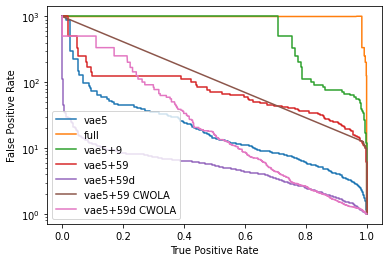

In [67]:
#now plot the ROCS
def lossPred(iX_te,iModel,iVAEs):
    iX_te_loss = []
    for vae in iVAEs:
        pX_te_loss = vaeloss(vae,iX_te)
        iX_te_loss.append(pX_te_loss)
    iX_te_lossN    = np.transpose(np.array(iX_te_loss))
    iY_pred = iModel.predict(iX_te_lossN)
    return iY_pred
    
#Now some rocs, lets compare the single VAE loss with the double loss and full
x59_loss5 = vaeloss(vae5,x_te59)
y_pred_full59     = model_full59.predict(x_te59)
y_pred_loss59     = lossPred(x_te59,model_loss59,[vae5,vae9])
y_pred_loss559    = lossPred(x_te59,model_loss559,[vae5,vae59])
y_pred_loss559d   = lossPred(x_te59,model_loss559,[vae5,vae59d])
y_pred_loss559CW  = lossPred(x_te59,model_loss559CW,[vae5,vae59])
y_pred_loss559dCW = lossPred(x_te59,model_loss559dCW,[vae5,vae59d])

plot_roc_curve(x59_loss5,             y_te59,fpr,tpr,'vae5'    ,False)
plot_roc_curve(y_pred_full59    [:,0],y_te59,fpr,tpr,'full'    ,True)
plot_roc_curve(y_pred_loss59    [:,0],y_te59,fpr,tpr,'vae5+9'  ,True)
plot_roc_curve(y_pred_loss559   [:,0],y_te59,fpr,tpr,'vae5+59' ,True)
plot_roc_curve(y_pred_loss559d  [:,0],y_te59,fpr,tpr,'vae5+59d',True)
plot_roc_curve(y_pred_loss559CW [:,0],y_te59,fpr,tpr,'vae5+59 CWOLA' ,True)
plot_roc_curve(y_pred_loss559dCW[:,0],y_te59,fpr,tpr,'vae5+59d CWOLA',True)
plt.legend(loc="lower left")
plt.show()

In [69]:
#alright now lets try CWOLA style training on a large dimensional dataset
#Now finally lets do the same search with an AE on each digit
vaeN = []
for i0 in range(9):
    tmpx_te = x_te[(y_te == i0)]
    tmpy_te = y_te[(y_te == i0)]
    tmpx_tr = x_tr[(y_tr == i0)]
    tmpy_tr = y_tr[(y_tr == i0)]
    tmpvae,tmpgen,tmpx,tmpy,tmpmu,tmpvae_loss = makeModel(tmpx_tr)
    tmpvae.fit(tmpx_tr,
               shuffle=True,
               epochs=n_epoch,
               batch_size=10,
               validation_data=(tmpx_te, None), verbose=1)
    vaeN.append(tmpvae)

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_212 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_212.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5923 samples, validate on 980 samples
Epoch 1/15
5923/5923 [==============================] - 2s 275us/step - loss: 165.3938 - val_loss: 137.4079
Epoch 2/15
5923/5923 [==============================] - 1s 243us/step - loss: 129.7028 - val_loss: 128.3828
Epoch 3/15
5923/5923 [==============================] - 1s 247us/step - loss: 126.2596 - val_loss: 127.0867
Epoch 4/15
5923/5923 [==============================] - 1s 239us/step - loss: 124.6787 - val_loss: 127.3295
Epoch 5/15
5923/5923 [==============================] - 1s 250us/step - loss: 123.5306 - val_loss: 124.0135
Epoch 6/15
5923/5923 [==============================] - 1s 252us/step - loss: 122.4730 - val_loss: 123.9660
Epoch 7/15
5923/5923 [==============================] - 1s 252us/step - loss: 121.4231 - val_loss: 122.2678
Epoch 8/15
5923/5923 [==============================] - 2s 257us/step - loss: 120.4256 - val_loss: 120.6819
Epoch 9/15
5923/5923 [==============================] - 2s 260us/step - loss: 119.3736 - 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_219 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_219.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 6742 samples, validate on 1135 samples
Epoch 1/15
6742/6742 [==============================] - 2s 295us/step - loss: 63.8338 - val_loss: 50.2459
Epoch 2/15
6742/6742 [==============================] - 2s 243us/step - loss: 48.3846 - val_loss: 44.0939
Epoch 3/15
6742/6742 [==============================] - 2s 300us/step - loss: 44.5892 - val_loss: 42.7795
Epoch 4/15
6742/6742 [==============================] - 2s 257us/step - loss: 43.6112 - val_loss: 43.1346
Epoch 5/15
6742/6742 [==============================] - 2s 254us/step - loss: 43.0748 - val_loss: 42.1016
Epoch 6/15
6742/6742 [==============================] - 2s 279us/step - loss: 42.6523 - val_loss: 42.2761
Epoch 7/15
6742/6742 [==============================] - 2s 266us/step - loss: 42.2563 - val_loss: 41.1566
Epoch 8/15
6742/6742 [==============================] - 2s 252us/step - loss: 41.8925 - val_loss: 41.0053
Epoch 9/15
6742/6742 [==============================] - 2s 250us/step - loss: 41.5499 - val_loss: 41.038

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_226 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_226.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5958 samples, validate on 1032 samples
Epoch 1/15
5958/5958 [==============================] - 2s 289us/step - loss: 204.3241 - val_loss: 154.7135
Epoch 2/15
5958/5958 [==============================] - 2s 262us/step - loss: 149.7888 - val_loss: 145.2280
Epoch 3/15
5958/5958 [==============================] - 2s 328us/step - loss: 143.8326 - val_loss: 140.9648
Epoch 4/15
5958/5958 [==============================] - 2s 267us/step - loss: 140.8611 - val_loss: 138.9889
Epoch 5/15
5958/5958 [==============================] - 1s 245us/step - loss: 138.6873 - val_loss: 137.0236
Epoch 6/15
5958/5958 [==============================] - 1s 237us/step - loss: 136.8840 - val_loss: 135.3140
Epoch 7/15
5958/5958 [==============================] - 1s 238us/step - loss: 135.5224 - val_loss: 134.6057
Epoch 8/15
5958/5958 [==============================] - 1s 239us/step - loss: 134.2076 - val_loss: 133.1157
Epoch 9/15
5958/5958 [==============================] - 1s 233us/step - loss: 133.2569 -

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_233 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_233.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 6131 samples, validate on 1010 samples
Epoch 1/15
6131/6131 [==============================] - 2s 279us/step - loss: 159.3356 - val_loss: 138.3112
Epoch 2/15
6131/6131 [==============================] - 1s 229us/step - loss: 133.5924 - val_loss: 131.6904
Epoch 3/15
6131/6131 [==============================] - 1s 224us/step - loss: 130.7103 - val_loss: 130.2250
Epoch 4/15
6131/6131 [==============================] - 1s 231us/step - loss: 129.3158 - val_loss: 128.4365
Epoch 5/15
6131/6131 [==============================] - 1s 237us/step - loss: 128.1864 - val_loss: 128.8507
Epoch 6/15
6131/6131 [==============================] - 1s 229us/step - loss: 127.1175 - val_loss: 126.2562
Epoch 7/15
6131/6131 [==============================] - 1s 232us/step - loss: 126.1695 - val_loss: 126.8914
Epoch 8/15
6131/6131 [==============================] - 1s 232us/step - loss: 125.3132 - val_loss: 125.8527
Epoch 9/15
6131/6131 [==============================] - 1s 238us/step - loss: 124.4920 -

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_240 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_240.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5842 samples, validate on 982 samples
Epoch 1/15
5842/5842 [==============================] - 2s 284us/step - loss: 152.7688 - val_loss: 122.4964
Epoch 2/15
5842/5842 [==============================] - 1s 244us/step - loss: 118.2824 - val_loss: 115.8574
Epoch 3/15
5842/5842 [==============================] - 1s 235us/step - loss: 113.7683 - val_loss: 112.4274
Epoch 4/15
5842/5842 [==============================] - 1s 232us/step - loss: 111.1940 - val_loss: 111.2874
Epoch 5/15
5842/5842 [==============================] - 1s 239us/step - loss: 109.3056 - val_loss: 108.4557
Epoch 6/15
5842/5842 [==============================] - 1s 237us/step - loss: 107.5912 - val_loss: 106.7835
Epoch 7/15
5842/5842 [==============================] - 1s 237us/step - loss: 106.2538 - val_loss: 105.1223
Epoch 8/15
5842/5842 [==============================] - 1s 242us/step - loss: 105.3345 - val_loss: 105.2091
Epoch 9/15
5842/5842 [==============================] - 1s 228us/step - loss: 104.5485 - 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_247 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_247.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5421 samples, validate on 892 samples
Epoch 1/15
5421/5421 [==============================] - 2s 298us/step - loss: 159.0280 - val_loss: 136.9859
Epoch 2/15
5421/5421 [==============================] - 2s 284us/step - loss: 131.7813 - val_loss: 129.9334
Epoch 3/15
5421/5421 [==============================] - 2s 284us/step - loss: 127.6588 - val_loss: 129.2336
Epoch 4/15
5421/5421 [==============================] - 2s 284us/step - loss: 125.7856 - val_loss: 127.1406
Epoch 5/15
5421/5421 [==============================] - 1s 239us/step - loss: 124.4550 - val_loss: 125.3317
Epoch 6/15
5421/5421 [==============================] - 1s 232us/step - loss: 123.3953 - val_loss: 124.9758
Epoch 7/15
5421/5421 [==============================] - 1s 234us/step - loss: 122.4692 - val_loss: 123.8555
Epoch 8/15
5421/5421 [==============================] - 1s 232us/step - loss: 121.6046 - val_loss: 125.2760
Epoch 9/15
5421/5421 [==============================] - 1s 233us/step - loss: 120.7351 - 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_254 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_254.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5918 samples, validate on 958 samples
Epoch 1/15
5918/5918 [==============================] - 2s 268us/step - loss: 155.9019 - val_loss: 122.8668
Epoch 2/15
5918/5918 [==============================] - 1s 231us/step - loss: 116.3678 - val_loss: 119.2048
Epoch 3/15
5918/5918 [==============================] - 1s 239us/step - loss: 112.1335 - val_loss: 113.6031
Epoch 4/15
5918/5918 [==============================] - 1s 240us/step - loss: 110.0911 - val_loss: 113.5323
Epoch 5/15
5918/5918 [==============================] - 1s 242us/step - loss: 108.4344 - val_loss: 110.9627
Epoch 6/15
5918/5918 [==============================] - 1s 235us/step - loss: 106.9334 - val_loss: 109.2411
Epoch 7/15
5918/5918 [==============================] - 1s 238us/step - loss: 105.6819 - val_loss: 108.8974
Epoch 8/15
5918/5918 [==============================] - 1s 237us/step - loss: 104.7029 - val_loss: 108.2502
Epoch 9/15
5918/5918 [==============================] - 1s 237us/step - loss: 103.8437 - 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_261 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_261.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 6265 samples, validate on 1028 samples
Epoch 1/15
6265/6265 [==============================] - 2s 271us/step - loss: 124.8941 - val_loss: 100.8603
Epoch 2/15
6265/6265 [==============================] - 1s 235us/step - loss: 99.0933 - val_loss: 96.8271
Epoch 3/15
6265/6265 [==============================] - 1s 233us/step - loss: 95.8091 - val_loss: 94.6718
Epoch 4/15
6265/6265 [==============================] - 1s 234us/step - loss: 93.6641 - val_loss: 92.3805
Epoch 5/15
6265/6265 [==============================] - 2s 240us/step - loss: 91.6883 - val_loss: 90.7206
Epoch 6/15
6265/6265 [==============================] - 1s 239us/step - loss: 90.0849 - val_loss: 89.6649
Epoch 7/15
6265/6265 [==============================] - 1s 237us/step - loss: 88.7627 - val_loss: 89.0766
Epoch 8/15
6265/6265 [==============================] - 1s 238us/step - loss: 87.8381 - val_loss: 87.8931
Epoch 9/15
6265/6265 [==============================] - 1s 235us/step - loss: 87.1399 - val_loss: 88.1

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_268 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_268.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5851 samples, validate on 974 samples
Epoch 1/15
5851/5851 [==============================] - 2s 267us/step - loss: 167.1301 - val_loss: 149.6996
Epoch 2/15
5851/5851 [==============================] - 1s 233us/step - loss: 139.6854 - val_loss: 140.5726
Epoch 3/15
5851/5851 [==============================] - 1s 234us/step - loss: 135.5192 - val_loss: 137.9022
Epoch 4/15
5851/5851 [==============================] - 1s 237us/step - loss: 133.9102 - val_loss: 135.7215
Epoch 5/15
5851/5851 [==============================] - 1s 231us/step - loss: 132.7369 - val_loss: 135.0561
Epoch 6/15
5851/5851 [==============================] - 1s 235us/step - loss: 131.8489 - val_loss: 135.8017
Epoch 7/15
5851/5851 [==============================] - 1s 235us/step - loss: 131.0937 - val_loss: 134.5642
Epoch 8/15
5851/5851 [==============================] - 1s 252us/step - loss: 130.4690 - val_loss: 136.7865
Epoch 9/15
5851/5851 [==============================] - 2s 275us/step - loss: 129.9400 - 

In [106]:
#model_loss59N    = lossClassify(x_tr59,x_te59,y_tr59,y_te59,256,vaeN,20,100) #ADWoP
#model_loss59NCW  = lossClassify(x_tr559,  x_te559,  y_tr559,  y_te559,  32,vaeN,100,50)
model_loss59NCWd = lossClassify(x_tr559d, x_te559d, y_tr559d, y_te559d, 32,vaeN,100,10)

Train on 5480 samples, validate on 902 samples
Epoch 1/100
5480/5480 [==============================] - 1s 146us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 2/100
5480/5480 [==============================] - 1s 102us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 3/100
5480/5480 [==============================] - 1s 99us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 4/100
5480/5480 [==============================] - 1s 101us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 5/100
5480/5480 [==============================] - 1s 99us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 6/100
5480/5480 [==============================] - 1s 102us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 7/100
5480/5480 [==============================] - 1s 102us/step - 

5480/5480 [==============================] - 0s 89us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 57/100
5480/5480 [==============================] - 0s 89us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 58/100
5480/5480 [==============================] - 0s 88us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 59/100
5480/5480 [==============================] - 1s 106us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 60/100
5480/5480 [==============================] - 1s 108us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 61/100
5480/5480 [==============================] - 1s 105us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - val_accuracy: 0.5055
Epoch 62/100
5480/5480 [==============================] - 1s 100us/step - loss: 7.6082 - accuracy: 0.5053 - val_loss: 7.5835 - v

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/

0.10108685507561987
0.9999200024888114
0.9965101085743999
0.999474460794553
0.9946523885923548
0.4830827485367122


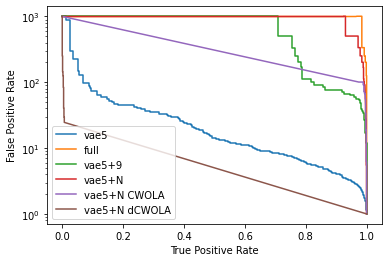

In [107]:
#Now some rocs, lets compare the single VAE loss with the double loss and full
y_pred_loss59N    = lossPred(x_te59,model_loss59N,vaeN)
y_pred_loss59NCW  = lossPred(x_te59,model_loss59NCW,vaeN)
y_pred_loss59NCWd = lossPred(x_te59,model_loss59NCWd,vaeN)

plot_roc_curve(x59_loss5,             y_te59,fpr,tpr,'vae5'    ,False)
plot_roc_curve(y_pred_full59    [:,0],y_te59,fpr,tpr,'full'    ,True)
plot_roc_curve(y_pred_loss59    [:,0],y_te59,fpr,tpr,'vae5+9'  ,True)
plot_roc_curve(y_pred_loss59N   [:,0],y_te59,fpr,tpr,'vae5+N'  ,True)
plot_roc_curve(y_pred_loss59NCW [:,0],y_te59,fpr,tpr,'vae5+N CWOLA',True)
plot_roc_curve(y_pred_loss59NCWd[:,0],y_te59,fpr,tpr,'vae5+N dCWOLA' ,True)
plt.legend(loc="lower left")
plt.show()

In [100]:
#now what if train with a a signal similar to 7 or if added it to our dilted sample
x_te7 = x_te[(y_te == 7)]
y_te7 = y_te[(y_te == 7)]
x_tr7 = x_tr[(y_tr == 7)]
y_tr7 = y_tr[(y_tr == 7)]

x_tr57,x_te57,y_tr57,y_te57         = mergeSample(x_te5,x_tr5,x_te7,x_tr7)
x_tr59d7,x_te59d7,y_tr59d7,y_te59d7 = mergeSample(x_te59d,x_tr59d,x_te7,x_tr7)
x_tr559d7,x_te559d7,y_tr559d7,y_te559d7 = mergeSample(x_te59d,x_tr59d,x_te7,x_tr7)


In [114]:
model_loss57N    = lossClassify(x_tr57,  x_te57,  y_tr57,  y_te57,  64,vaeN,10,100)
#model_loss57NCWd = lossClassify(x_tr559d7,  x_te559d7,  y_tr559d7,  y_te559d7,  32,vaeN,10,100)
#for freence on that is just on 7 and 5
model_loss57    = lossClassify(x_tr57,  x_te57,  y_tr57,  y_te57,  64,[vaeN[5],vaeN[7]],10,50)

Train on 11686 samples, validate on 1920 samples
Epoch 1/10
11686/11686 [==============================] - 0s 30us/step - loss: 7.1342 - accuracy: 0.5361 - val_loss: 7.1254 - val_accuracy: 0.5354
Epoch 2/10
11686/11686 [==============================] - 0s 11us/step - loss: 7.1342 - accuracy: 0.5361 - val_loss: 7.1254 - val_accuracy: 0.5354
Epoch 3/10
11686/11686 [==============================] - 0s 11us/step - loss: 7.1342 - accuracy: 0.5361 - val_loss: 7.1254 - val_accuracy: 0.5354
Epoch 4/10
11686/11686 [==============================] - 0s 11us/step - loss: 7.1342 - accuracy: 0.5361 - val_loss: 7.1254 - val_accuracy: 0.5354
Epoch 5/10
11686/11686 [==============================] - 0s 11us/step - loss: 7.1342 - accuracy: 0.5361 - val_loss: 7.1254 - val_accuracy: 0.5354
Epoch 6/10
11686/11686 [==============================] - 0s 11us/step - loss: 7.1342 - accuracy: 0.5361 - val_loss: 7.1254 - val_accuracy: 0.5354
Epoch 7/10
11686/11686 [==============================] - 0s 11us/ste

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/

0.10108685507561987
0.9999200024888114
0.9965101085743999
0.999474460794553
0.9921513552911686
0.9901725279657967
0.9936301981716125


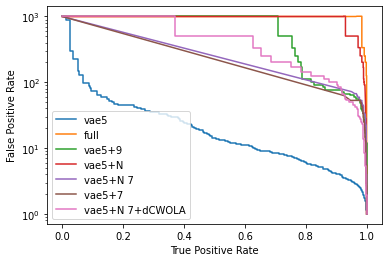

In [113]:
#Now some rocs, lets compare the single VAE loss with the double loss and full
y_pred_loss57     = lossPred(x_te59,model_loss57,[vaeN[5],vaeN[7]])
y_pred_loss57N    = lossPred(x_te59,model_loss57N,vaeN)
y_pred_loss57NCWd = lossPred(x_te59,model_loss57NCWd,vaeN)

plot_roc_curve(x59_loss5,             y_te59,fpr,tpr,'vae5'    ,False)
plot_roc_curve(y_pred_full59    [:,0],y_te59,fpr,tpr,'full'    ,True)
plot_roc_curve(y_pred_loss59    [:,0],y_te59,fpr,tpr,'vae5+9'  ,True)
plot_roc_curve(y_pred_loss59N   [:,0],y_te59,fpr,tpr,'vae5+N'  ,True)
plot_roc_curve(y_pred_loss57N   [:,0],y_te59,fpr,tpr,'vae5+N 7',True)
plot_roc_curve(y_pred_loss57    [:,0],y_te59,fpr,tpr,'vae5+7  ',True)
plot_roc_curve(y_pred_loss57NCWd[:,0],y_te59,fpr,tpr,'vae5+N 7+dCWOLA' ,True)
plt.legend(loc="lower left")
plt.show()

In [122]:
#now lets make a diluted 9 signal sample merged with 7
dilution=0.2
x_te9dp, y_te9dp = random_sample(x_te9,y_te9,dilution)
x_tr9dp, y_tr9dp = random_sample(x_tr9,y_tr9,dilution)

x_tr79dp,x_te79dp,y_tr79dp,y_te79dp         = mergeSample(x_te7,x_tr7,x_te9dp,x_tr9dp)
x_tr579dp,x_te579dp,y_tr579dp,y_te579dp     = mergeSample(x_te5,x_tr5,x_te79dp,x_tr79dp)

In [123]:
model_loss579dpN    = lossClassify(x_tr579dp,  x_te579dp,  y_tr579dp,  y_te579dp,  64,vaeN,50,100)

Train on 12875 samples, validate on 2121 samples
Epoch 1/50
12875/12875 [==============================] - 0s 27us/step - loss: 0.0964 - accuracy: 0.9879 - val_loss: 0.0628 - val_accuracy: 0.9910
Epoch 2/50
12875/12875 [==============================] - 0s 12us/step - loss: 0.0414 - accuracy: 0.9936 - val_loss: 0.0603 - val_accuracy: 0.9915
Epoch 3/50
12875/12875 [==============================] - 0s 11us/step - loss: 0.0364 - accuracy: 0.9932 - val_loss: 0.1097 - val_accuracy: 0.9859
Epoch 4/50
12875/12875 [==============================] - 0s 11us/step - loss: 0.0268 - accuracy: 0.9945 - val_loss: 0.0567 - val_accuracy: 0.9915
Epoch 5/50
12875/12875 [==============================] - 0s 11us/step - loss: 0.0242 - accuracy: 0.9952 - val_loss: 0.0469 - val_accuracy: 0.9939
Epoch 6/50
12875/12875 [==============================] - 0s 11us/step - loss: 0.0212 - accuracy: 0.9950 - val_loss: 0.0473 - val_accuracy: 0.9929
Epoch 7/50
12875/12875 [==============================] - 0s 11us/ste

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


0.10108685507561987
0.9999200024888114
0.999474460794553
0.999298910700556


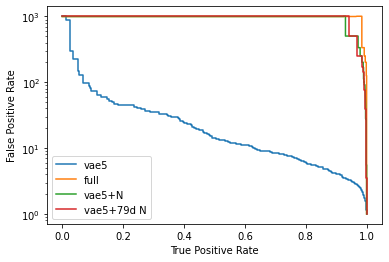

In [124]:
#Now some rocs, lets compare the single VAE loss with the double loss and full
y_pred_loss579dpN = lossPred(x_te59,model_loss579dpN,vaeN)

plot_roc_curve(x59_loss5,             y_te59,fpr,tpr,'vae5'    ,False)
plot_roc_curve(y_pred_full59    [:,0],y_te59,fpr,tpr,'full'    ,True)
plot_roc_curve(y_pred_loss59N   [:,0],y_te59,fpr,tpr,'vae5+N'  ,True)
plot_roc_curve(y_pred_loss579dpN[:,0],y_te59,fpr,tpr,'vae5+79d N' ,True)
plt.legend(loc="lower left")
plt.show()

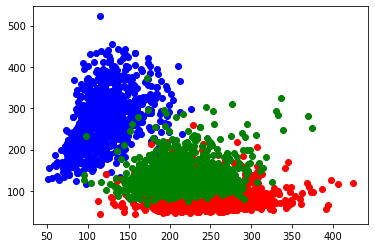

In [125]:
#now lets see how we can do this by avoiding training an NN to classify
#since 7 works well lets take a look at the space

x5_loss5 = vaeloss(vaeN[5],x_te5)
x7_loss5 = vaeloss(vaeN[5],x_te7)
x9_loss5 = vaeloss(vaeN[5],x_te9)

x5_loss7 = vaeloss(vaeN[7],x_te5)
x7_loss7 = vaeloss(vaeN[7],x_te7)
x9_loss7 = vaeloss(vaeN[7],x_te9)

plt.scatter(x5_loss5, x5_loss7,c='blue')
plt.scatter(x7_loss5, x7_loss7,c='red')
plt.scatter(x9_loss5, x9_loss7,c='green')
plt.show()


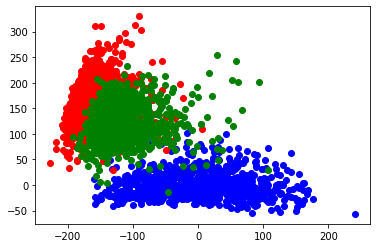

(892, 1)


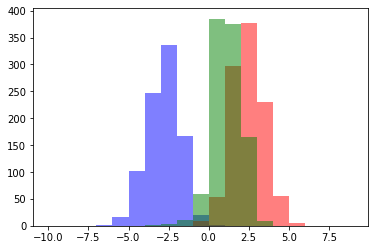

(1901, 2) (1901, 2)
0.07764425106774456
0.9934579813072482
0.9964045563026928
0.9969500948859369
0.9999200024888114
0.999298910700556


/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/

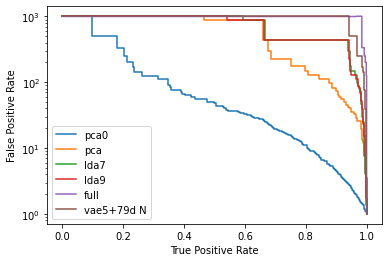

In [195]:
#In this space we can rotate along the axis of maximal separation
from sklearn.decomposition import PCA
x5_losstmp = np.transpose(np.array([x5_loss5,x5_loss7]))
x7_losstmp = np.transpose(np.array([x7_loss5,x7_loss7]))
x9_losstmp = np.transpose(np.array([x9_loss5,x9_loss7]))
x_losstmp  = np.concatenate((x5_losstmp,x7_losstmp)) 
x_losstmp9 = np.concatenate((x5_losstmp,x9_losstmp)) 
y_losstmp  = np.hstack((np.zeros(len(x5_losstmp)), np.ones(len(x7_losstmp))))
y_losstmp9 = np.hstack((np.zeros(len(x5_losstmp)), np.ones(len(x9_losstmp))))

pca = PCA(n_components=2)
x5_losspca = pca.fit(x5_losstmp)
x5_losspca = pca.transform(x5_losstmp)
x7_losspca = pca.transform(x7_losstmp)
x9_losspca = pca.transform(x9_losstmp)
plt.scatter(x5_losspca[:,0], x5_losspca[:,1],c='blue')
plt.scatter(x7_losspca[:,0], x7_losspca[:,1],c='red')
plt.scatter(x9_losspca[:,0], x9_losspca[:,1],c='green')
plt.show()

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda7 = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
ytmp=lda7.fit(x_losstmp, y_losstmp).transform(x_losstmp)
x5_losslda = lda7.transform(x5_losstmp)
x7_losslda = lda7.transform(x7_losstmp)
x9_losslda = lda7.transform(x9_losstmp)
#now the truth
lda9 = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
ytmp=lda9.fit(x_losstmp9, y_losstmp9)
x5_losslda9 = lda9.transform(x5_losstmp)
x9_losslda9 = lda9.transform(x9_losstmp)

bins=np.arange(-10,10)
print(x5_losslda.shape)
plt.hist(x5_losslda,bins,color='b',alpha=0.5)
plt.hist(x7_losslda,bins,color='r',alpha=0.5)
plt.hist(x9_losslda,bins,color='g',alpha=0.5)
plt.show()

x59_losspca  = np.concatenate((x5_losspca,x9_losspca)) 
x59_losslda  = np.concatenate((x5_losslda,x9_losslda)) 
x59_losslda9 = np.concatenate((x5_losslda9,x9_losslda9)) 
y_te59loss = np.hstack((np.ones(len(x5_losspca)), np.zeros(len(x9_losspca))))
y_te59loss = np.eye(2)[((y_te59loss)).astype(int)]
print(y_te59.shape,y_te59loss.shape)

plot_roc_curve(x59_losspca[:,0],y_te59loss,fpr,tpr,'pca0'      ,False)
plot_roc_curve(x59_losspca[:,1],y_te59loss,fpr,tpr,'pca'       ,True)
plot_roc_curve(x59_losslda[:,0],y_te59loss,fpr,tpr,'lda7'      ,True)
plot_roc_curve(x59_losslda9[:,0],y_te59loss,fpr,tpr,'lda9'      ,True)
plot_roc_curve(y_pred_full59    [:,0],y_te59,fpr,tpr,'full'       ,True)
plot_roc_curve(y_pred_loss579dpN[:,0],y_te59,fpr,tpr,'vae5+79d N' ,True)
plt.legend(loc="lower left")
plt.show()

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


0.9971578661997182
0.9988311474754119
0.9999200024888114
0.999298910700556


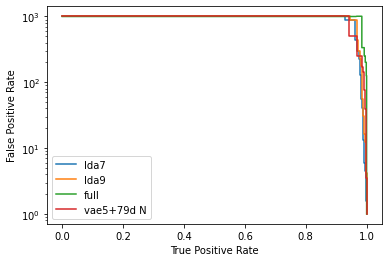

In [199]:
#now what if we do this in a higher dimensional space 
def lossN(iX_te,iVAEs):
    X_te_lossN = []
    for vae in iVAEs:
        pX_te_loss = vaeloss(vae,iX_te)
        X_te_lossN.append(pX_te_loss)
    X_te_lossN    = np.transpose(np.array(X_te_lossN))
    return X_te_lossN

x5_lossNtmp = lossN(x_te5,vaeN)
x7_lossNtmp = lossN(x_te7,vaeN)
x9_lossNtmp = lossN(x_te9,vaeN)

x_lossNtmp  = np.concatenate((x5_lossNtmp,x7_lossNtmp)) 
x_lossNtmp9 = np.concatenate((x5_lossNtmp,x9_lossNtmp)) 
y_lossNtmp  = np.hstack((np.zeros(len(x5_lossNtmp)), np.ones(len(x7_lossNtmp))))
y_lossNtmp9 = np.hstack((np.zeros(len(x5_lossNtmp)), np.ones(len(x9_lossNtmp))))

lda7 = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda7.fit(x_lossNtmp, y_lossNtmp)
x5_losslda = lda7.transform(x5_lossNtmp)
x9_losslda = lda7.transform(x9_lossNtmp)
#now the truth
lda9 = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda9.fit(x_lossNtmp9, y_lossNtmp9)
x5_losslda9 = lda9.transform(x5_lossNtmp)
x9_losslda9 = lda9.transform(x9_lossNtmp)

x59_losslda  = np.concatenate((x5_losslda,x9_losslda)) 
x59_losslda9 = np.concatenate((x5_losslda9,x9_losslda9)) 

plot_roc_curve(x59_losslda[:,0],y_te59loss,fpr,tpr,'lda7'      ,True)
plot_roc_curve(x59_losslda9[:,0],y_te59loss,fpr,tpr,'lda9'      ,True)
plot_roc_curve(y_pred_full59    [:,0],y_te59,fpr,tpr,'full'       ,True)
plot_roc_curve(y_pred_loss579dpN[:,0],y_te59,fpr,tpr,'vae5+79d N' ,True)
plt.legend(loc="lower left")
plt.show()


In [ ]:
#so with lda7 and an N dimensional signal space we are approach the fully optimal scenario